In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *
from paraparticle_utils import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import concurrent.futures
plt.rcParams.update({'font.size': 12})

np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x000001CCC47D8A40> at 0x000001CCDCD63C40>

In [2]:
# we want to model the spin 1/2 xx model to compare the dynamics of free fermions to free paraparticles

In [3]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
id = np.eye(2)

# Function
def single_site_operator(N, site, operator):
    if not (1 <= site <= N):
        raise ValueError("Site must be between 1 and N")
    
    full_operator = 1  # Start with scalar 1 for tensor product
    for i in range(1, N + 1):  # Loop over all N sites
        if i == site:
            full_operator = np.kron(full_operator, operator)
        else:
            full_operator = np.kron(full_operator, id)
    
    return full_operator

In [4]:
def construct_single_spin_basis():
    return [["↑"], ["↓"]]

def construct_multispin_basis(N):
    if N < 1:
        raise ValueError("N must be a positive integer")
    
    # Single-spin basis
    single_basis = ["↑", "↓"]
    # Initialize basis with empty list
    basis = []
    
    # Generate all 2^N combinations using binary counting
    for i in range(2**N):
        # Convert i to binary, pad with zeros to length N
        binary = format(i, f'0{N}b')
        # Map 0 to ↑ and 1 to ↓
        state = [single_basis[int(bit)] for bit in binary]
        basis.append(state)
    
    return basis

def construct_spin_xx_hamiltonian(N, J, boundary_conditions = "OBC"):
    if N < 2:
        raise ValueError("N must be at least 2 for interactions")
    
    H = np.zeros([2**N, 2**N], dtype=complex)
    for i in range(1, N):
        H += -J/4 * (single_site_operator(N, i, sigma_x) @ single_site_operator(N, i+1, sigma_x) +
                     single_site_operator(N, i, sigma_y) @ single_site_operator(N, i+1, sigma_y))
    if boundary_conditions == "PBC":
        H += -J/4 * (single_site_operator(N, N, sigma_x) @ single_site_operator(N, 1, sigma_x) +
                     single_site_operator(N, N, sigma_y) @ single_site_operator(N, 1, sigma_y))
    return H

def construct_site_fermion_number_operator(N, site):
    sigma_z_i = single_site_operator(N, site, sigma_z)
    id_i = single_site_operator(N, site, id)
    return (sigma_z_i + id_i) / 2

def construct_total_fermion_number_operator(N):
    if N < 1:
        raise ValueError("N must be a positive integer")
    
    operator = np.zeros([2**N, 2**N], dtype=complex)
    for i in range(1, N+1):
        # n_i = (sigma^z_i + I_i) / 2
        sigma_z_i = single_site_operator(N, i, sigma_z)
        id_i = single_site_operator(N, i, id)
        operator += (sigma_z_i + id_i) / 2
    return operator

def construct_fermion_creation_operator(N, site):
    if not (1 <= site <= N):
        raise ValueError("Site must be between 1 and N")
    if N < 1:
        raise ValueError("N must be a positive integer")
    
    # Define sigma^+ = (sigma^x + i sigma^y) / 2
    sigma_plus = (sigma_x + 1j * sigma_y) / 2
    
    # Initialize with sigma^+ at site j
    operator = single_site_operator(N, site, sigma_plus)
    
    # Apply sigma^z string for sites 1 to j-1
    for k in range(1, site):
        sigma_z_k = single_site_operator(N, k, sigma_z)
        operator = operator @ sigma_z_k
    
    return operator

def construct_fermion_annihilation_operator(N, site):
    if not (1 <= site <= N):
        raise ValueError("Site must be between 1 and N")
    if N < 1:
        raise ValueError("N must be a positive integer")
    
    # Define sigma^- = (sigma^x - i sigma^y) / 2
    sigma_minus = (sigma_x - 1j * sigma_y) / 2
    
    # Initialize with sigma^- at site j
    operator = single_site_operator(N, site, sigma_minus)
    
    # Apply sigma^z string for sites 1 to j-1
    for k in range(1, site):
        sigma_z_k = single_site_operator(N, k, sigma_z)
        operator = sigma_z_k @ operator
    
    return operator
        

In [5]:
N = 4
J = 4

H = construct_spin_xx_hamiltonian(N, J)
eigenvalues, eigenvectors = exact_diagonalize(H)

In [6]:
basis = construct_multispin_basis(N)

for idx in range(len(eigenvalues)):
    print(f"state {idx} has energy {eigenvalues[idx]}")
    state = eigenvectors[idx]
    for i in range(len(basis)):
        print(f"{np.round(state[i],3)} * {basis[i]}")
    print()

state 0 has energy -4.472135954999571
0j * ['↑', '↑', '↑', '↑']
0j * ['↑', '↑', '↑', '↓']
0j * ['↑', '↑', '↓', '↑']
(-0.224+0j) * ['↑', '↑', '↓', '↓']
0j * ['↑', '↓', '↑', '↑']
(-0.5+0j) * ['↑', '↓', '↑', '↓']
(-0.447+0j) * ['↑', '↓', '↓', '↑']
0j * ['↑', '↓', '↓', '↓']
0j * ['↓', '↑', '↑', '↑']
(-0.447+0j) * ['↓', '↑', '↑', '↓']
(-0.5+0j) * ['↓', '↑', '↓', '↑']
0j * ['↓', '↑', '↓', '↓']
(-0.224+0j) * ['↓', '↓', '↑', '↑']
0j * ['↓', '↓', '↑', '↓']
0j * ['↓', '↓', '↓', '↑']
0j * ['↓', '↓', '↓', '↓']

state 1 has energy -3.23606797749978
0j * ['↑', '↑', '↑', '↑']
(0.372-0j) * ['↑', '↑', '↑', '↓']
(0.602-0j) * ['↑', '↑', '↓', '↑']
0j * ['↑', '↑', '↓', '↓']
(0.602+0j) * ['↑', '↓', '↑', '↑']
0j * ['↑', '↓', '↑', '↓']
0j * ['↑', '↓', '↓', '↑']
0j * ['↑', '↓', '↓', '↓']
(0.372+0j) * ['↓', '↑', '↑', '↑']
0j * ['↓', '↑', '↑', '↓']
0j * ['↓', '↑', '↓', '↑']
0j * ['↓', '↑', '↓', '↓']
0j * ['↓', '↓', '↑', '↑']
0j * ['↓', '↓', '↑', '↓']
0j * ['↓', '↓', '↓', '↑']
0j * ['↓', '↓', '↓', '↓']

state 2 h

In [7]:
total_fermion_number_op = construct_total_fermion_number_operator(N)

for i, state in enumerate(eigenvectors):
    total_fermion_number = state.conj().T @ total_fermion_number_op @ state
    print(f"state {i} with energy {eigenvalues[i]} has {np.round(total_fermion_number,3)} fermions")
    if total_fermion_number == 0j:
        fermion_vacuum = state

state 0 with energy -4.472135954999571 has (2+0j) fermions
state 1 with energy -3.23606797749978 has (3+0j) fermions
state 2 with energy -3.23606797749978 has (1+0j) fermions
state 3 with energy -1.9999999999999982 has (2+0j) fermions
state 4 with energy -1.236067977499789 has (3+0j) fermions
state 5 with energy -1.236067977499789 has (1+0j) fermions
state 6 with energy 0.0 has (2+0j) fermions
state 7 with energy 0.0 has (4+0j) fermions
state 8 with energy 0.0 has (2+0j) fermions
state 9 with energy 0.0 has 0j fermions
state 10 with energy 1.236067977499793 has (1+0j) fermions
state 11 with energy 1.236067977499793 has (3+0j) fermions
state 12 with energy 2.000000000000005 has (2+0j) fermions
state 13 with energy 3.23606797749979 has (1+0j) fermions
state 14 with energy 3.23606797749979 has (3+0j) fermions
state 15 with energy 4.47213595499958 has (2+0j) fermions


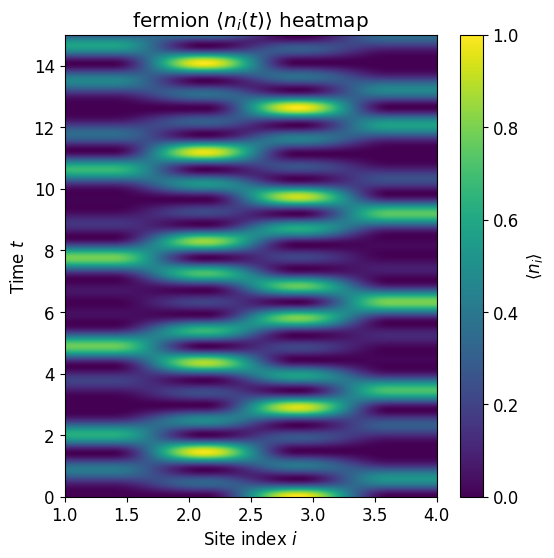

In [8]:
# first, let's look at the dynamics of a single fermion

times = np.linspace(0, 15, 500)

# Precompute site number operators
site_ops = [construct_site_fermion_number_operator(N, site=i+1) for i in range(N)]

# one paraparticle state

one_fermion_state = construct_fermion_creation_operator(N, 3) @ fermion_vacuum

# Time evolution
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=one_fermion_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'fermion $\langle n_i(t) \rangle$ heatmap')
plt.show()


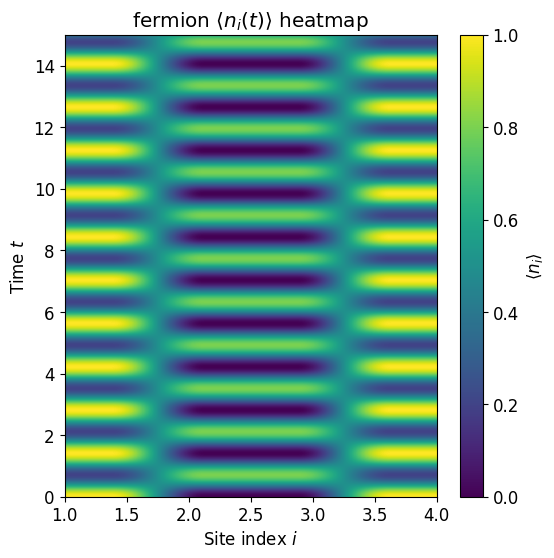

In [9]:
# and now, let's look at the dynamics of a two fermions

times = np.linspace(0, 15, 500)

# Precompute site number operators
site_ops = [construct_site_fermion_number_operator(N, site=i+1) for i in range(N)]

# one paraparticle state

two_fermion_state = construct_fermion_creation_operator(N, N) @ construct_fermion_creation_operator(N, 1) @ fermion_vacuum

# Time evolution
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_fermion_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'fermion $\langle n_i(t) \rangle$ heatmap')
plt.show()


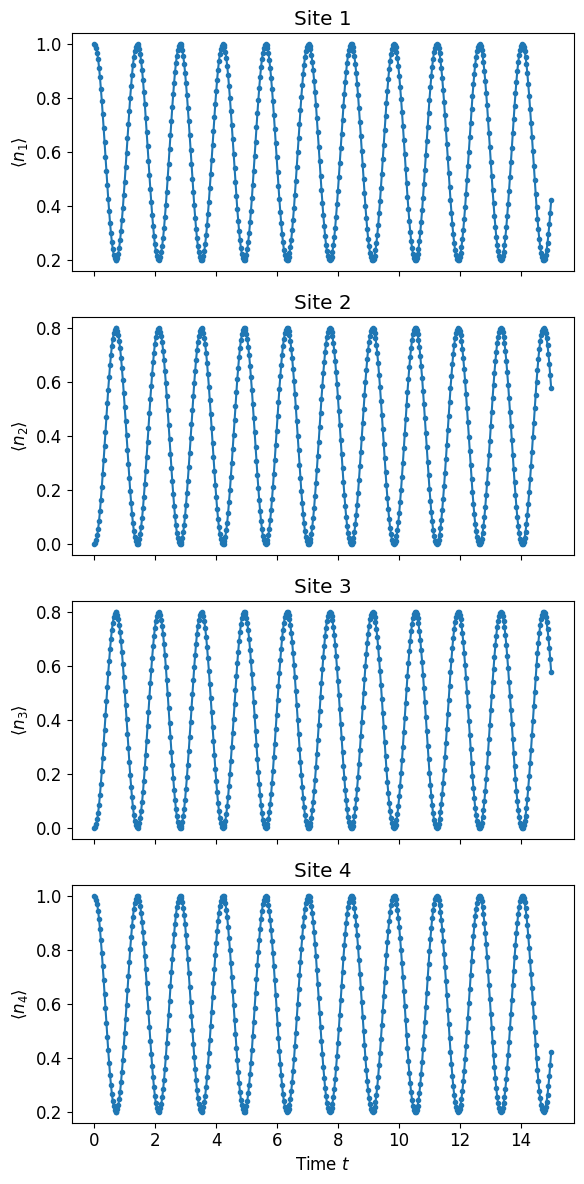

In [10]:
# Evolve system
times = np.linspace(0, 15, 500)
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_fermion_state
)

# Prepare subplots
fig, axes = plt.subplots(nrows=N, sharex=True, figsize=(6, 3*N))

# Handle case where num_sites = 1 (axes is not a list)
if N == 1:
    axes = [axes]

# Plot expectation values
for site_idx in range(N):
    op = site_ops[site_idx]
    exp_values = [
        np.real(state.conj().T @ op @ state)
        for state in time_evolved_wavefunctions
    ]
    axes[site_idx].plot(times, exp_values, '.-')
    axes[site_idx].set_ylabel(rf"$\langle n_{site_idx+1} \rangle$")
    axes[site_idx].set_title(rf"Site {site_idx+1}")

axes[-1].set_xlabel(r"Time $t$")
fig.tight_layout()
plt.show()
